In [57]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

import xgboost as xgb
import numpy as np
from typing import Tuple
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import sympy as sp

In [58]:
titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

In [59]:
X_transformed = pd.get_dummies(X, drop_first=True)
display(X.head())
display(X_transformed.head())

,gender,age,class,embarked,fare,sibsp,parch
0,male,42.0,3rd,Southampton,7.11,0,0
1,male,13.0,3rd,Southampton,20.05,0,2
2,male,16.0,3rd,Southampton,20.05,1,1
3,female,39.0,3rd,Southampton,20.05,1,1
4,female,16.0,3rd,Southampton,7.13,0,0


,age,fare,sibsp,parch,gender_male,class_2nd,class_3rd,class_deck crew,class_engineering crew,class_restaurant staff,class_victualling crew,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,42.0,7.11,0,0,True,False,True,False,False,False,False,False,False,True
1,13.0,20.05,0,2,True,False,True,False,False,False,False,False,False,True
2,16.0,20.05,1,1,True,False,True,False,False,False,False,False,False,True
3,39.0,20.05,1,1,False,False,True,False,False,False,False,False,False,True
4,16.0,7.13,0,0,False,False,True,False,False,False,False,False,False,True


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [61]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [63]:
y, y_hut = sp.symbols('y y_hut')
lambda_reg = sp.symbols('lambda_reg')
f = sp.Function('f')(y, y_hut, lambda_reg)

f = (y_hut-y)**2 + lambda_reg*(y_hut**2)

grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

y_pred = dtrain.get_label()
y_rel = dtrain.get_label()

lambda_r = 0.1
grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

if type(grad) == float:
    grad = np.ones(y_pred.shape[0]) * grad

if type(hess) == float:
    hess = np.ones(y_pred.shape[0]) * hess


In [198]:
# Backup

def XGBoost_changed(lambda_r: float, dtrain: xgb.DMatrix) -> xgb.Booster:
    def objective_function(y_pred: np.ndarray, dtrain_: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        y, y_hut = sp.symbols('y y_hut', real=True)
        lambda_reg = sp.symbols('lambda_reg')
        f = sp.Function('f')(y, y_hut, lambda_reg)

        f = (y_hut-y)**2 + lambda_reg*y_hut

        grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
        hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

        y_rel = dtrain_.get_label()

        grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

        if type(grad) in [float, int]:
            grad = np.ones(y_pred.shape[0]) * grad
        if type(hess) in [float, int]:
            hess = np.ones(y_pred.shape[0]) * hess
        
        return grad, hess
    
    params = {
        # 'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'seed': 2001,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=8,
        obj=objective_function,
        evals=[(dtrain, 'train')]
    )
    return model

In [64]:
# import numpy as np
# import matplotlib.pyplot as plt

titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

henry = pd.DataFrame({'gender'   : ['male'],
                       'age'     : [47],
                       'class'   : ['1st'],
                       'embarked': ['Cherbourg'],
                       'fare'    : [25],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['Henry'])

cp_henry = titanic_rf_exp.predict_profile(henry)

df = cp_henry.result

p = np.polynomial.polynomial.Polynomial.fit(df['age'], df['_yhat_'], 4)

x_vals = np.linspace(min(df['age'])-5, max(df['age'])+5, 100)
# Evaluate the polynomial at the x values
y_vals = p(x_vals)

# plt.scatter(df['age'], df['_yhat_'], color='red', label='Data Points')
# plt.plot(x_vals, y_vals, label='Polynomial Fit')
# plt.xlabel('Domain')
# plt.ylabel('Range')
# plt.legend()
# plt.title('Polynomial Fit')
# plt.show()

p(150)



Calculating ceteris paribus: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


7.063394819180315

In [65]:
p

Polynomial([ 0.32062298,  0.03888729, -0.08910767, -0.13972538,  0.13088347], domain=[ 0.16666667, 74.        ], window=[-1.,  1.], symbol='x')

In [ ]:
y, y_hut = sp.symbols('y y_hut', real=True)
f = sp.Function('f')(y_hut)

y_hut = dtrain.get_label()
df = pd.DataFrame(dtrain.get_data().toarray())


# f = ()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,30.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,29.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,41.0,13.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,23.0,9.0406,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,47.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1761,29.0,26.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1762,37.0,8.1303,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1763,23.0,13.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
# Test

list = []
def XGBoost_changed(lambda_r: float, dtrain: xgb.DMatrix, lambda_k: float) -> xgb.Booster:
    def objective_function(y_pred: np.ndarray, dtrain_: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        w = np.matmul(y_pred, np.linalg.pinv(dtrain.get_data().toarray()).T)

        y, y_hut = sp.symbols('y y_hut', real=True)
        lambda_reg = sp.symbols('lambda_reg')
        lambda_known = sp.symbols('lambda_known')
        f = sp.Function('f')(y, y_hut, lambda_reg)

        f = (y_hut-y)**2 + lambda_reg * y_hut + lambda_known * y_hut**2

        grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
        hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

        y_rel = dtrain_.get_label()
        
        list.append(w)

        grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

        if type(grad) in [float, int]:
            grad = np.ones(y_pred.shape[0]) * grad
        if type(hess) in [float, int]:
            hess = np.ones(y_pred.shape[0]) * hess
        
        return grad, hess
    
    params = {
        # 'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'seed': 2001,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=8,
        obj=objective_function,
        # evals=[(dtrain, 'train')]
    )
    return model

In [200]:
model = XGBoost_changed(float(2), dtrain)
set = dtest
pred = model.predict(set)

print(balanced_accuracy_score(dtest.get_label(), model.predict(dtest) > 0.5))
print(accuracy_score(dtest.get_label(), model.predict(dtest) > 0.5))

TypeError: XGBoost_changed() missing 1 required positional argument: 'lambda_k'

In [ ]:
arr = np.arange(0, 2, 0.05)
df = pd.DataFrame()

for lambda_r in arr:
    model = XGBoost_changed(float(lambda_r), dtrain)
    set = dtest
    pred = model.predict(set)
    df = pd.concat([df, pd.DataFrame({'lambda_reg': lambda_r, 
                  'test': balanced_accuracy_score(dtest.get_label(), model.predict(dtest) > 0.5),
                  'train': balanced_accuracy_score(dtrain.get_label(), model.predict(dtrain) > 0.5)},
                  index=[0])])

<Axes: title={'center': 'Regularization impact on accuracy'}, xlabel='lambda_reg'>

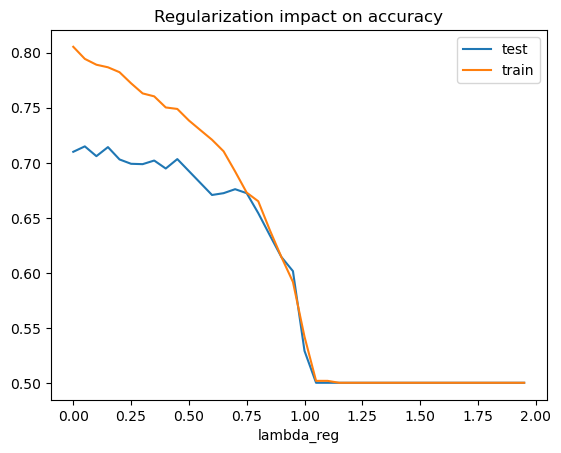

In [ ]:
df.plot(x='lambda_reg', y=['test', 'train'], title='Regularization impact on accuracy')

In [ ]:
y, y_hut = sp.symbols('y y_hut', real=True)
lambda_reg = sp.symbols('lambda_reg')
f = sp.Function('f')(y, y_hut, lambda_reg)

f = (y_hut-y)**2 + lambda_reg*abs(y_hut)

grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

y_rel = dtrain.get_label()

# grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

# if type(grad) in [float, int]:
#     grad = np.ones(y_pred.shape[0]) * grad
# if type(hess) in [float, int]:
#     hess = np.ones(y_pred.shape[0]) * hess
        
# grad, hess

# f.diff(y_hut)
y_pred = np.linspace(0, 1, 15)
y_rel = np.linspace(0, 10, 15)

y_pred = wT*xi
w = xiT-1*y_pred


y_pred - y_rel


    
    # params = {
    #     # 'objective': 'reg:squarederror',
    #     'tree_method': 'hist',
    #     'seed': 2001,
    # }

    # model = xgb.train(
    #     params=params,
    #     dtrain=dtrain,
    #     num_boost_round=100,
    #     obj=objective_function
    # )
    # return model

NameError: name 'wT' is not defined

In [164]:
y = dtrain.get_label()
X = dtrain.get_data()

w = np.matmul(y, np.linalg.pinv(dtrain.get_data().toarray()).T)

sum(w**2)


1.5160378499108447

In [ ]:
y_sym = sp.Matrix(y)
X_sym = sp.Matrix(dtrain.get_data().toarray())
w_sym = X_sym.pinv() * y_sym

w_sym



Matrix([
[ 0.00219299],
[ 0.00193368],
[ -0.0210271],
[ 0.00222679],
[  -0.398258],
[   0.182997],
[  0.0506906],
[   0.728183],
[   0.237934],
[-0.00182493],
[   0.250975],
[   0.583744],
[   0.438101],
[   0.371981]])

In [209]:
df = pd.DataFrame()
df['gain'] = model.get_score(importance_type='gain')
df['weight'] = model.get_score(importance_type='weight')
df['cover'] = model.get_score(importance_type='cover')

In [210]:
df

,gain,weight,cover
age,0.730222,135.0,333.200012
fare,1.027053,102.0,344.254913
sibsp,1.395434,16.0,215.250000
parch,0.467154,12.0,300.333344
gender_male,41.281654,8.0,3530.000000
class_2nd,0.766686,5.0,953.200012
class_3rd,6.242602,10.0,839.000000
class_deck crew,6.357002,6.0,2628.666748
class_engineering crew,1.382401,2.0,2131.000000
class_restaurant staff,1.269791,2.0,2366.000000


In [11]:
import dalex as dx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

preprocess = make_column_transformer(
    (StandardScaler(), ['age', 'fare', 'parch', 'sibsp']),
    (OneHotEncoder(), ['gender', 'class', 'embarked']))



titanic_rf = make_pipeline(
    preprocess,
    RandomForestClassifier(max_depth = 3, n_estimators = 500))
titanic_rf.fit(X, y)

titanic_rf_exp = dx.Explainer(titanic_rf, 
                    X, y, label = "Titanic RF Pipeline")

henry = pd.DataFrame({'gender'   : ['male'],
                       'age'     : [47],
                       'class'   : ['1st'],
                       'embarked': ['Cherbourg'],
                       'fare'    : [25],
                       'sibsp'   : [0],
                       'parch'   : [0]},
                      index = ['Henry'])

cp_henry = titanic_rf_exp.predict_profile(henry)
cp_henry.result

cp_henry.plot(variables = ['age', 'fare'])

Preparation of a new explainer is initiated

  -> data              : 2207 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x0000020D2D996980> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.169, mean = 0.322, max = 0.887
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.827, mean = -0.000136, max = 0.825
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


In [13]:
import sympy as sp
df = cp_henry.result

df = df.reset_index()
df = df[['age', '_yhat_']]

df = df.groupby('age', as_index=False).agg({'_yhat_': 'mean'})

x = sp.symbols('x')
# s = sp.interpolating_spline(1, x, df.age, df._yhat_)


In [14]:
s

NameError: name 's' is not defined

In [16]:
punkty = list(zip(df['age'], df['_yhat_']))

punkty

[(0.1666666667, 0.42276230618067645),
 (0.905000000033, 0.42276230618067645),
 (1.643333333366, 0.42026737395640046),
 (2.3816666666989996, 0.42026737395640046),
 (3.120000000032, 0.42026737395640046),
 (3.858333333365, 0.4147473501252094),
 (4.596666666698, 0.38845950729586487),
 (5.335000000031, 0.38845950729586487),
 (6.073333333364, 0.3827955724975694),
 (6.8116666666970005, 0.37658807047122184),
 (7.550000000030001, 0.37658807047122184),
 (8.288333333363, 0.37658807047122184),
 (9.026666666695998, 0.3710748359994853),
 (9.765000000029, 0.3408197643368283),
 (10.503333333361999, 0.33918532890326625),
 (11.241666666695, 0.33918532890326625),
 (11.980000000028, 0.33918532890326625),
 (12.718333333360999, 0.33684037390003607),
 (13.456666666694, 0.33684037390003607),
 (14.195000000027, 0.31622804985025055),
 (14.93333333336, 0.3115007244221276),
 (15.671666666693, 0.3083736672899877),
 (16.410000000026, 0.3083736672899877),
 (17.148333333359, 0.30251710396721676),
 (17.886666666691998

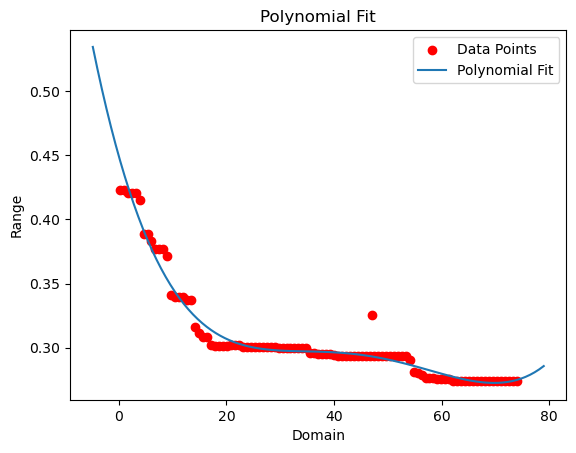

4.9833351002291755

In [54]:
import numpy as np
import matplotlib.pyplot as plt

p = np.polynomial.polynomial.Polynomial.fit(df['age'], df['_yhat_'], 4)

x_vals = np.linspace(min(df['age'])-5, max(df['age'])+5, 100)
# Evaluate the polynomial at the x values
y_vals = p(x_vals)

plt.scatter(df['age'], df['_yhat_'], color='red', label='Data Points')
plt.plot(x_vals, y_vals, label='Polynomial Fit')
plt.xlabel('Domain')
plt.ylabel('Range')
plt.legend()
plt.title('Polynomial Fit')
plt.show()

p(150)

In [56]:
import xgboost as xgb

dtrain = xgb.DMatrix(X, label=y)



ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:gender: object, class: object, embarked: object

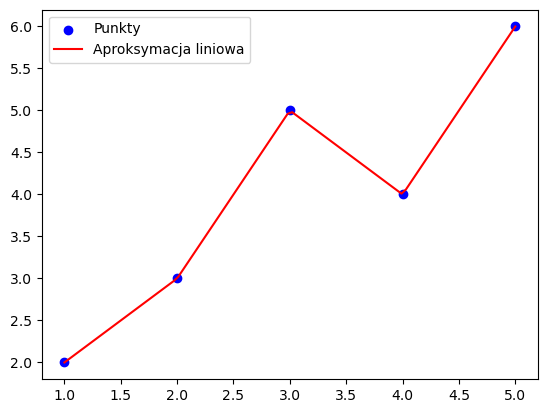

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Przykładowa ramka danych
# data = {'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 4, 6]}
# df = pd.DataFrame(data)

# Interpolacja liniowa
f_liniowa = interp1d(df['age'], df['_yhat_'], kind='linear')

# Generowanie nowych punktów
x_new = np.linspace(df['age'].min(), df['age'].max(), 100)
y_new = f_liniowa(x_new)

# Wizualizacja
plt.scatter(df['age'], df['_yhat_'], color='blue', label='Punkty')
plt.plot(x_new, y_new, color='red', label='Aproksymacja liniowa')
plt.legend()
plt.show()


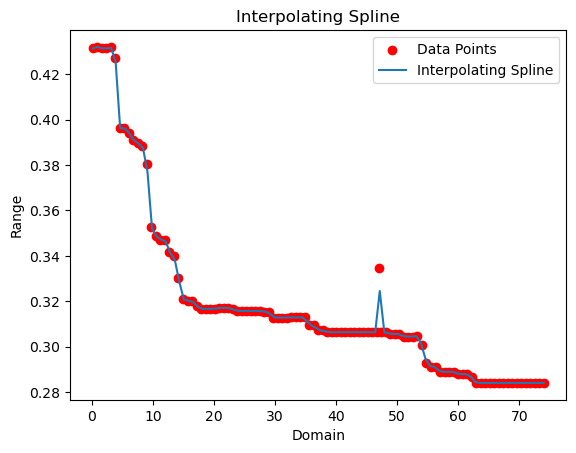

Piecewise((0.000902934537246436*x + 0.431315329890357, (x >= 0.1666666667) & (x <= 0.905000000033)), (0.432888354721115 - 0.000835214446953114*x, (x >= 0.905000000033) & (x <= 1.643333333366)), (0.431515818979928, (x >= 1.643333333366) & (x <= 2.381666666699)), (0.00050347962675934*x + 0.430316698335514, (x >= 2.381666666699) & (x <= 3.120000000032)), (0.450752547150095 - 0.00604647191630847*x, (x >= 3.120000000032) & (x <= 3.858333333365)), (0.589970210670641 - 0.0421288037139942*x, (x >= 3.858333333365) & (x <= 4.596666666698)), (0.396318142930661, (x >= 4.596666666698) & (x <= 5.335000000031)), (0.410501635971875 - 0.00265857414079329*x, (x >= 5.335000000031) & (x <= 6.073333333364)), (0.420281903063131 - 0.00426893644999282*x, (x >= 6.073333333364) & (x <= 6.811666666697)), (0.405864238336904 - 0.002152323081826*x, (x >= 6.811666666697) & (x <= 7.55000000003)), (0.400200840949329 - 0.00140220422254766*x, (x >= 7.55000000003) & (x <= 8.288333333363)), (0.479764335353279 - 0.01100166

In [359]:
import numpy as np

import matplotlib.pyplot as plt

# Define the data points
DataPointsDomain = df.age
DataPointsRange = df._yhat_

# Define the symbol and the spline
x = sp.symbols('x')
s = sp.interpolating_spline(1, x, DataPointsDomain, DataPointsRange)

# Generate x values for plotting
x_vals = np.linspace(min(DataPointsDomain), max(DataPointsDomain), 100)
# Evaluate the spline at the x values
y_vals = [s.evalf(subs={x: val}) for val in x_vals]

# Plot the data points and the spline
plt.scatter(DataPointsDomain, DataPointsRange, color='red', label='Data Points')
plt.plot(x_vals, y_vals, label='Interpolating Spline')
plt.xlabel('Domain')
plt.ylabel('Range')
plt.legend()
plt.title('Interpolating Spline')
plt.show()

display(s)